In [1]:
import jupyterthemes
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim
import torch.nn.functional as F
desired_width=320
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns',10)

plt.rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))


In [2]:
# Heavily based on https://github.com/Prodicode/ann-visualizer
def ann_viz(model, view=True, filename="network.gv"):
    """Vizualizez a Sequential model.

    # Arguments
        model: A Keras model instance.

        view: whether to display the model after generation.

        filename: where to save the vizualization. (a .gv file)

        title: A title for the graph
    """
    from graphviz import Digraph

    input_layer = 0
    hidden_layers_nr = 0
    layer_types = []
    hidden_layers = []
    output_layer = 0
    layers = [layer for layer in model.modules() if type(layer) == torch.nn.Linear]

    for layer in layers:
        if layer == layers[0]:
            input_layer = layer.in_features
            hidden_layers_nr += 1
            if type(layer) == torch.nn.Linear:                
                hidden_layers.append(layer.out_features)
                layer_types.append("Dense")
            else:
                raise Exception("Input error")

        else:
            if layer == layers[-1]:
                output_layer = layer.out_features
            else:
                hidden_layers_nr += 1
                if type(layer) == torch.nn.Linear:

                    hidden_layers.append(layer.out_features)
                    layer_types.append("Dense")
                else:
                    raise Exception("Hidden error")
        last_layer_nodes = input_layer
        nodes_up = input_layer

    g = Digraph("g", filename=filename)
    n = 0
    g.graph_attr.update(splines="false", nodesep="0.5", ranksep="0", rankdir='LR')
    # Input Layer
    with g.subgraph(name="cluster_input") as c:
        if type(layers[0]) == torch.nn.Linear:
            the_label = "Input Layer"
            if layers[0].in_features > 10:
                the_label += " (+" + str(layers[0].in_features - 10) + ")"
                input_layer = 10
            c.attr(color="white")
            for i in range(0, input_layer):
                n += 1
                c.node(str(n))
                c.attr(labeljust="1")
                c.attr(label=the_label, labelloc="bottom")
                c.attr(rank="same")                
                c.node_attr.update(
                    width="0.65",
                    style="filled",                    
                    shape="circle",
                    color=HAPPY_COLORS_PALETTE[3],
                    fontcolor=HAPPY_COLORS_PALETTE[3],
                )
    for i in range(0, hidden_layers_nr):
        with g.subgraph(name="cluster_" + str(i + 1)) as c:
            if layer_types[i] == "Dense":
                c.attr(color="white")
                c.attr(rank="same")
                the_label = f'Hidden Layer {i + 1}'
                if layers[i].out_features > 10:
                    the_label += " (+" + str(layers[i].out_features - 10) + ")"
                    hidden_layers[i] = 10
                c.attr(labeljust="right", labelloc="b", label=the_label)
                for j in range(0, hidden_layers[i]):
                    n += 1
                    c.node(
                        str(n),
                        width="0.65",
                        shape="circle",
                        style="filled",
                        color=HAPPY_COLORS_PALETTE[0],
                        fontcolor=HAPPY_COLORS_PALETTE[0],
                    )
                    for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                        g.edge(str(h), str(n))
                last_layer_nodes = hidden_layers[i]
                nodes_up += hidden_layers[i]
            else:
                raise Exception("Hidden layer type not supported")

    with g.subgraph(name="cluster_output") as c:
        if type(layers[-1]) == torch.nn.Linear:
            c.attr(color="white")
            c.attr(rank="same")
            c.attr(labeljust="1")
            for i in range(1, output_layer + 1):
                n += 1
                c.node(
                    str(n),
                    width="0.65",
                    shape="circle",
                    style="filled",
                    color=HAPPY_COLORS_PALETTE[4],
                    fontcolor=HAPPY_COLORS_PALETTE[4],
                    
                )
                for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                    g.edge(str(h), str(n))
            c.attr(label="Output Layer", labelloc="bottom")
            c.node_attr.update(
                color="#2ecc71", style="filled", fontcolor="#2ecc71", shape="circle"
            )

    g.attr(arrowShape="none")
    g.edge_attr.update(arrowhead="none", color="#707070", penwidth="2")
    if view is True:
        g.view()

    return g

# Data preprocessing

In [3]:
df = pd.read_csv(r'C:\Users\fikri\Desktop\pyproj\ANN\weather\weatherAUS.csv')
print(df.head())
print(df.columns)
print(df.shape)
print(df.isna().sum())


         Date Location  MinTemp  MaxTemp  Rainfall  ...  Cloud3pm  Temp9am Temp3pm  RainToday RainTomorrow
0  2008-12-01   Albury     13.4     22.9       0.6  ...       NaN     16.9    21.8         No           No
1  2008-12-02   Albury      7.4     25.1       0.0  ...       NaN     17.2    24.3         No           No
2  2008-12-03   Albury     12.9     25.7       0.0  ...       2.0     21.0    23.2         No           No
3  2008-12-04   Albury      9.2     28.0       0.0  ...       NaN     18.1    26.5         No           No
4  2008-12-05   Albury     17.5     32.3       1.0  ...       8.0     17.8    29.7         No           No

[5 rows x 23 columns]
Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow'], dtype='object')
(14

In [4]:
cols = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']
df = df[cols]
print(df.head())

   Rainfall  Humidity3pm  Pressure9am RainToday RainTomorrow
0       0.6         22.0       1007.7        No           No
1       0.0         25.0       1010.6        No           No
2       0.0         30.0       1007.6        No           No
3       0.0         16.0       1017.6        No           No
4       1.0         33.0       1010.8        No           No


In [5]:
df['RainToday'].replace(['No','no','yes','Yes'],['0','0','1','1'],inplace =True)
df['RainTomorrow'].replace(['No','no','yes','Yes'],['0','0','1','1'],inplace =True)
print(df.head().dtypes)

Rainfall        float64
Humidity3pm     float64
Pressure9am     float64
RainToday        object
RainTomorrow     object
dtype: object


In [6]:
df = df.dropna(how='any')

In [7]:
df['RainToday'].astype('int32')
df['RainTomorrow'].astype('int32')

0         0
1         0
2         0
3         0
4         0
         ..
145454    0
145455    0
145456    0
145457    0
145458    0
Name: RainTomorrow, Length: 124689, dtype: int32

0    0.778762
1    0.221238
Name: RainTomorrow, dtype: float64

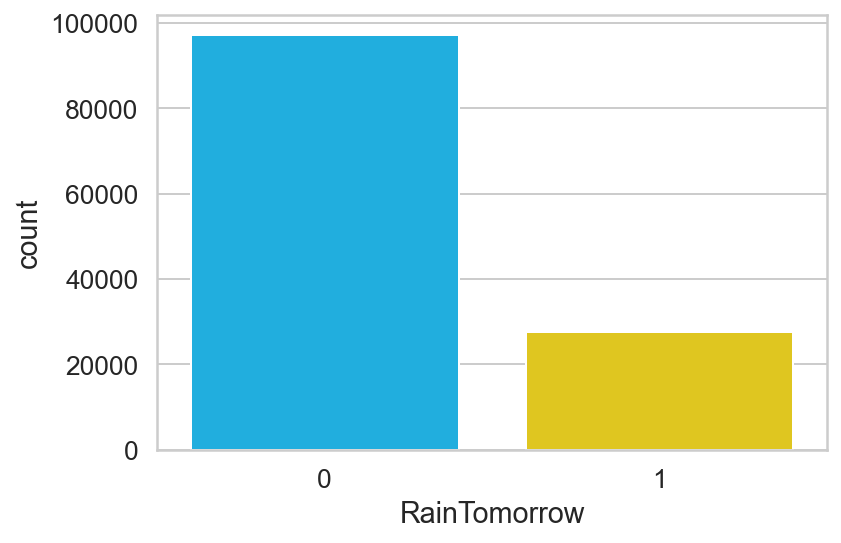

In [8]:
sns.countplot(x='RainTomorrow', data=df)
df.RainTomorrow.value_counts() / df.shape[0]

In [9]:
X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']].astype('int32')
y = df[['RainTomorrow']].astype('int32')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [10]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print( X_train.shape, y_train.shape)
print( X_test.shape, y_test.shape)


torch.Size([99751, 4]) torch.Size([99751])
torch.Size([24938, 4]) torch.Size([24938])


# create model

In [11]:

class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

In [12]:
net = Net(X_train.shape[1])

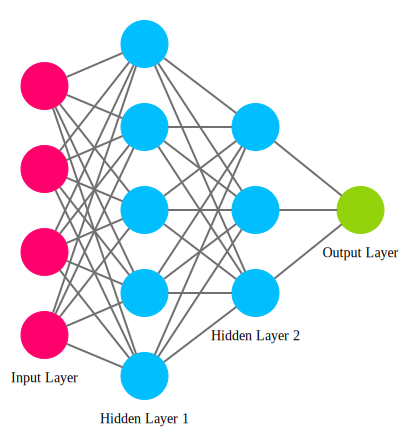

In [13]:
ann_viz(net, view=False)

# Training

In [14]:
criterion = nn.BCELoss()

In [15]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
!nvidia-smi

Thu Feb 18 20:56:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 431.84       Driver Version: 431.84       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 105... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   40C    P8    N/A /  N/A |     75MiB /  4096MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [18]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

net = net.to(device)
criterion = criterion.to(device)

In [19]:
def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [20]:

epoch2 = []
loss2 = []
acc1 = []
for epoch in range(1000):
    y_pred = net(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred,y_train)
    train_acc = calculate_accuracy(y_train, y_pred)
    epoch2.append(epoch)
    loss2.append(train_loss.item())
    acc1.append(train_acc.item())
    if epoch % 100 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)
      y_test_pred = net(X_test)
      y_test_pred = torch.squeeze(y_test_pred)

      test_loss = criterion(y_test_pred, y_test)
      test_acc = calculate_accuracy(y_test, y_test_pred)

      print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

epoch 0
Train set - loss: 2.514, accuracy: 0.779
Test  set - loss: 2.518, accuracy: 0.778

epoch 100
Train set - loss: 0.458, accuracy: 0.792
Test  set - loss: 0.459, accuracy: 0.793

epoch 200
Train set - loss: 0.435, accuracy: 0.8
Test  set - loss: 0.436, accuracy: 0.8

epoch 300
Train set - loss: 0.421, accuracy: 0.813
Test  set - loss: 0.421, accuracy: 0.815

epoch 400
Train set - loss: 0.413, accuracy: 0.826
Test  set - loss: 0.413, accuracy: 0.827

epoch 500
Train set - loss: 0.408, accuracy: 0.831
Test  set - loss: 0.408, accuracy: 0.832

epoch 600
Train set - loss: 0.406, accuracy: 0.833
Test  set - loss: 0.406, accuracy: 0.834

epoch 700
Train set - loss: 0.405, accuracy: 0.834
Test  set - loss: 0.405, accuracy: 0.835

epoch 800
Train set - loss: 0.404, accuracy: 0.834
Test  set - loss: 0.404, accuracy: 0.835

epoch 900
Train set - loss: 0.404, accuracy: 0.834
Test  set - loss: 0.404, accuracy: 0.836



<AxesSubplot:xlabel='epoch', ylabel='loss'>

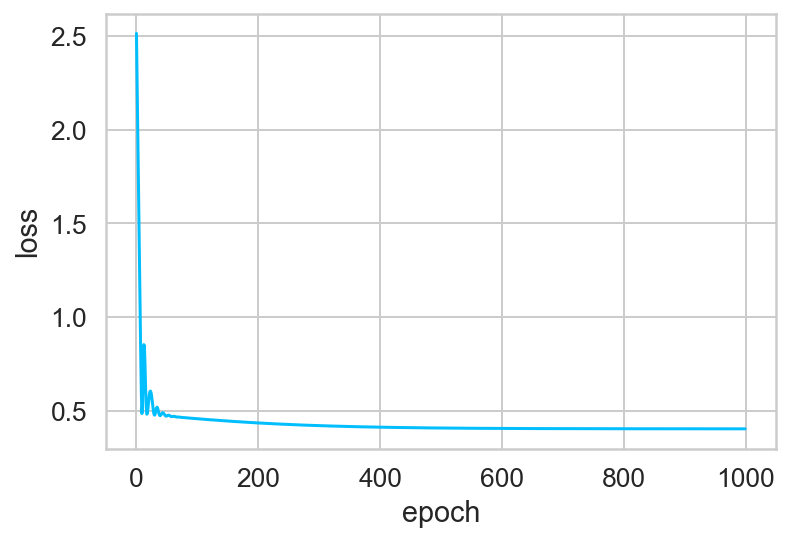

In [21]:
history = pd.DataFrame({'epoch' : epoch2 , 'loss' : loss2, 'acc' : acc1 })
sns.lineplot(x='epoch', y='loss',data=history)



<AxesSubplot:xlabel='epoch', ylabel='acc'>

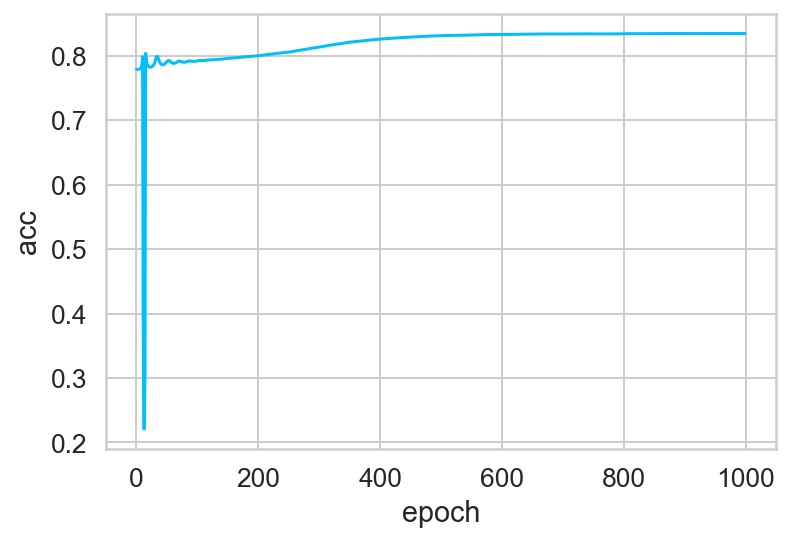

In [22]:
sns.lineplot(x='epoch', y='acc',data=history)

In [23]:
MODEL_PATH = 'model.pth'

torch.save(net, MODEL_PATH)

In [24]:
classes = ['No rain', 'Raining']
y_pred = net(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.85      0.96      0.90     19413
     Raining       0.74      0.40      0.52      5525

    accuracy                           0.84     24938
   macro avg       0.80      0.68      0.71     24938
weighted avg       0.83      0.84      0.82     24938



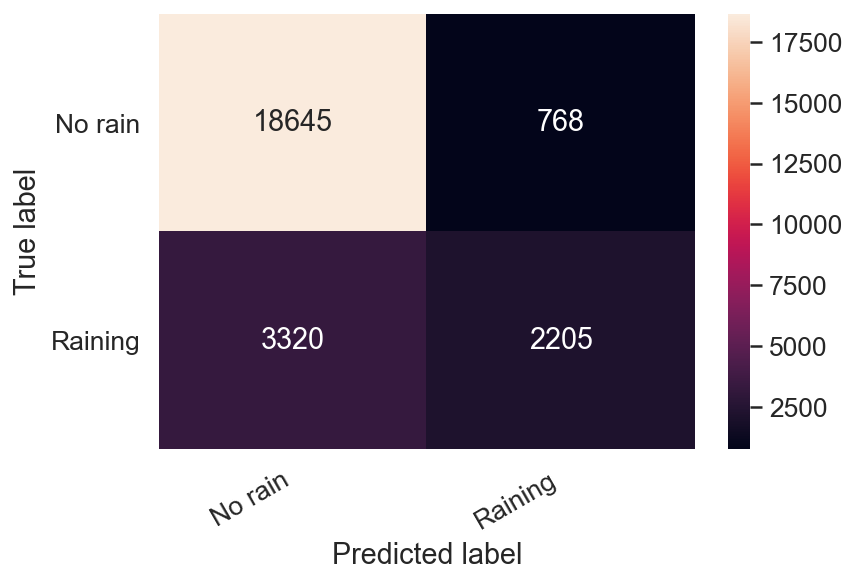

In [25]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [26]:
def will_it_rain(rainfall, humidity, rain_today, pressure):
  t = torch.as_tensor([rainfall, humidity, rain_today, pressure]) \
      .float() \
      .to(device)
  output = net(t)
  return output.ge(0.5).item()